In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set a seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define the dataset class
class VideoDataset(Dataset):
    def __init__(self, data_dir, clip_length=16, transform=None):
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.clips = self._load_clips(clip_length)
        self.transform = transform

    def _load_clips(self, clip_length):
        clips = []
        for class_name in self.classes:
            class_path = os.path.join(self.data_dir, class_name)
            for video_file in os.listdir(class_path):
                video_path = os.path.join(class_path, video_file)
                cap = cv2.VideoCapture(video_path)
                frames = []
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (128, 128))
                    frames.append(frame)
                    if len(frames) == clip_length:
                        clips.append((frames.copy(), self.class_to_idx[class_name]))
                        frames.pop(0)  # Remove the oldest frame
                cap.release()
        return clips

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        frames, label = self.clips[idx]
        frames = np.stack(frames, axis=0)
        if self.transform:
            frames = self.transform(frames)
        return frames, label

# Define a transform for data preprocessing (e.g., resizing and normalization)
from torchvision import transforms


# Create the dataset
data_dir = '/content/drive/MyDrive/miniproj2_ds_vid'
clip_length = 16
dataset = VideoDataset(data_dir, clip_length=clip_length, transform=None)

# Split the dataset into training and validation sets (80-20 split)
total_samples = len(dataset)
split_ratio = 0.8
train_size = int(split_ratio * total_samples)
val_size = total_samples - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [15]:
# Define the CNN model (you can modify this architecture as needed)
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2),

        )
        self.fc_layers = nn.Sequential(
            nn.Linear(30752, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [16]:
import matplotlib.pyplot as plt

# Initialize lists to store training loss, validation loss, training accuracy, and validation accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the model, loss function, and optimizer
num_classes = len(dataset.classes)
model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    print(device)
    model.train()
    total_loss = 0.0
    total_val_loss = 0.0
    for batch_data, labels in train_loader:
        batch_data, labels = batch_data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data.transpose(2,4).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}")

    # Calculate training accuracy
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for batch_data, labels in train_loader:
            batch_data, labels = batch_data.to(device), labels.to(device)
            outputs = model(batch_data.transpose(2, 4).float())
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)

    # Validation accuracy calculation (similar to training accuracy calculation)
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_data, labels in val_loader:
            batch_data, labels = batch_data.to(device), labels.to(device)
            outputs = model(batch_data.transpose(2, 4).float())
            loss = criterion(outputs, labels)
            total_val_loss+=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = (correct_val / total_val) * 100
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}, Validation Accuracy: {val_accuracy:.2f}%")

    # Append training and validation losses to their respective lists
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(total_val_loss/len(val_loader))


cuda
Epoch 1/5, Training Loss: 1.289324234343114
Epoch 1/5, Training Loss: 1.289324234343114, Validation Accuracy: 95.05%
cuda
Epoch 2/5, Training Loss: 0.2409455455443063
Epoch 2/5, Training Loss: 0.2409455455443063, Validation Accuracy: 91.62%
cuda
Epoch 3/5, Training Loss: 0.2262628026622223
Epoch 3/5, Training Loss: 0.2262628026622223, Validation Accuracy: 96.22%
cuda
Epoch 4/5, Training Loss: 0.23018410651617152
Epoch 4/5, Training Loss: 0.23018410651617152, Validation Accuracy: 96.73%
cuda
Epoch 5/5, Training Loss: 0.15503122810957576
Epoch 5/5, Training Loss: 0.15503122810957576, Validation Accuracy: 97.12%


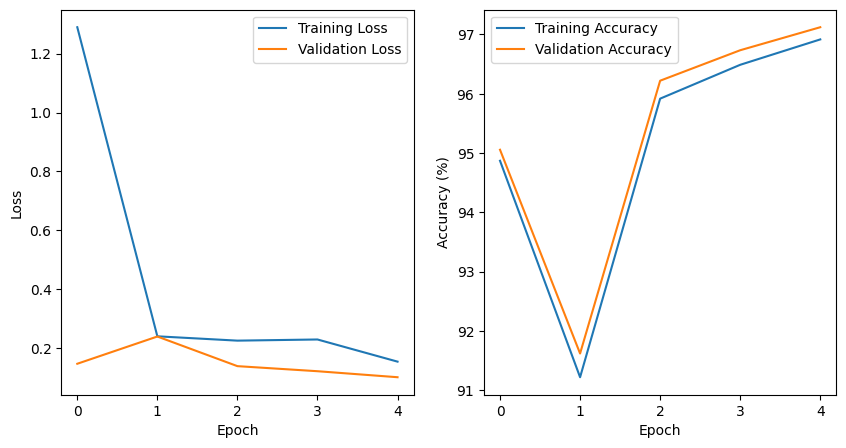

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [5]:

# Evaluation loop on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_data, labels in val_loader:
        batch_data, labels = batch_data.to(device), labels.to(device)
        outputs = model(batch_data.transpose(2,4).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {(correct / total) * 100:.2f}%")

Validation Accuracy: 97.56%


In [6]:
model_save_path = 'model_vanilla_5_epoch.pth'

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model_vanilla_5_epoch.pth


## New Validation

In [7]:
import random

# Define a function to randomly select frames and repeat them to create 16 frames
def create_random_clip(frames, clip_length=16):
    if len(frames) >= clip_length:
        # Randomly select 2 to 8 frames
        num_frames_to_select = random.randint(2, 8)
        start_idx = random.randint(0, len(frames) - num_frames_to_select)
        selected_frames = frames[start_idx:start_idx + num_frames_to_select]

        # Repeat selected frames to create a clip of length 16
        clip = selected_frames.repeat(clip_length,1,1,1)
    else:
        # If there are not enough frames, repeat the available frames
        clip = frames.repeat(clip_length,1,1,1)
    return clip[:clip_length,:,:,:]

# Evaluation loop on the validation set with random clips
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_data, labels in val_loader:
        batch_data, labels = batch_data.to(device), labels.to(device)

        # Create a list to store the new batch data with random clips
        new_batch_data = []

        for video_clip in batch_data:
            # Create a random clip from the original 16 frames
            random_clip = create_random_clip(video_clip)
            new_batch_data.append(random_clip)

        new_batch_data = torch.stack(new_batch_data)
        outputs = model(new_batch_data.transpose(2,4).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy with Random Clips: {(correct / total) * 100:.2f}%")


Validation Accuracy with Random Clips: 93.42%


# Improved Model

In [18]:
# Define the CNN model (you can modify this architecture as needed)
class CNNModel_Improved(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel_Improved, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(in_channels = 16, out_channels = 64, kernel_size = 3, stride = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2),
            nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (1,3,3), stride = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(6272, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [19]:
import matplotlib.pyplot as plt

# Initialize lists to store training loss, validation loss, training accuracy, and validation accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the model, loss function, and optimizer
num_classes = len(dataset.classes)
model = CNNModel_Improved(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    print(device)
    model.train()
    total_loss = 0.0
    total_val_loss = 0.0
    for batch_data, labels in train_loader:
        batch_data, labels = batch_data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data.transpose(2,4).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}")

    # Calculate training accuracy
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for batch_data, labels in train_loader:
            batch_data, labels = batch_data.to(device), labels.to(device)
            outputs = model(batch_data.transpose(2, 4).float())
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)

    # Validation accuracy calculation (similar to training accuracy calculation)
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_data, labels in val_loader:
            batch_data, labels = batch_data.to(device), labels.to(device)
            outputs = model(batch_data.transpose(2, 4).float())
            loss = criterion(outputs, labels)
            total_val_loss+=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = (correct_val / total_val) * 100
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}, Validation Accuracy: {val_accuracy:.2f}%")

    # Append training and validation losses to their respective lists
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(total_val_loss/len(val_loader))


cuda
Epoch 1/5, Training Loss: 0.5196479981641825
Epoch 1/5, Training Loss: 0.5196479981641825, Validation Accuracy: 96.92%
cuda
Epoch 2/5, Training Loss: 0.1572924689713429
Epoch 2/5, Training Loss: 0.1572924689713429, Validation Accuracy: 97.49%
cuda
Epoch 3/5, Training Loss: 0.1469116248045002
Epoch 3/5, Training Loss: 0.1469116248045002, Validation Accuracy: 98.34%
cuda
Epoch 4/5, Training Loss: 0.11645018788229579
Epoch 4/5, Training Loss: 0.11645018788229579, Validation Accuracy: 95.73%
cuda
Epoch 5/5, Training Loss: 0.13496867378316066
Epoch 5/5, Training Loss: 0.13496867378316066, Validation Accuracy: 97.91%


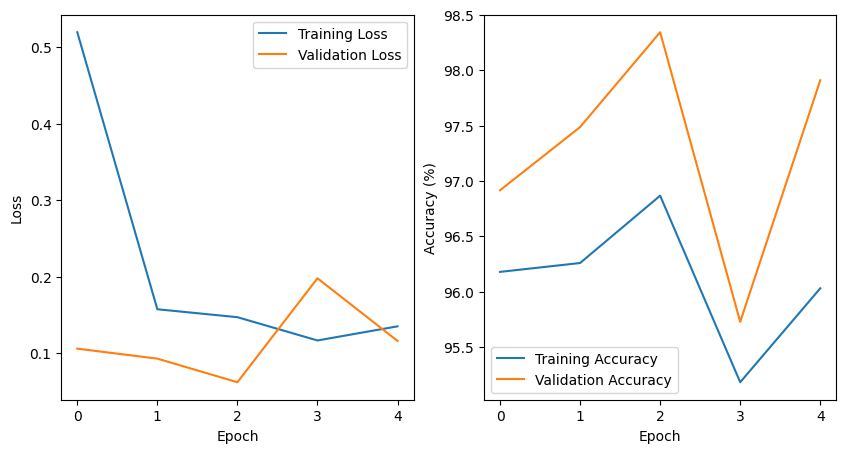

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [10]:

# Evaluation loop on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_data, labels in val_loader:
        batch_data, labels = batch_data.to(device), labels.to(device)
        outputs = model(batch_data.transpose(2,4).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {(correct / total) * 100:.2f}%")

Validation Accuracy: 99.68%


Validation Accuracy: 98.82%

In [11]:
model_save_path = 'model_improved_5_epoch.pth'

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model_improved_5_epoch.pth


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_data, labels in val_loader:
        batch_data, labels = batch_data.to(device), labels.to(device)

        # Create a list to store the new batch data with random clips
        new_batch_data = []

        for video_clip in batch_data:
            # Create a random clip from the original 16 frames
            random_clip = create_random_clip(video_clip)
            new_batch_data.append(random_clip)

        new_batch_data = torch.stack(new_batch_data)
        outputs = model(new_batch_data.transpose(2,4).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy with Random Clips: {(correct / total) * 100:.2f}%")

Validation Accuracy with Random Clips: 98.82%


Validation Accuracy with Random Clips: 98.38%

In [13]:
dataset.class_to_idx

{'punch': 0, 'pick': 1, 'laugh': 2, 'pour': 3, 'pullup': 4}